# Set up

In [1]:
# Load required packages
from google.colab import drive
import os
import pickle
import numpy as np
import re
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from nltk.translate.bleu_score import corpus_bleu
from PIL import Image
import matplotlib.pyplot as plt

# Mount google drive (that is where the dataset is stored)
drive.mount('/content/gdrive')

# Navagate to the folder in drive where the dataset is located
% cd /content/gdrive/MyDrive/DL_ASG_3

# Assign path to working directory to variable DIR
DIR = '/content/gdrive/MyDrive/DL_ASG_3'

Mounted at /content/gdrive
/content/gdrive/MyDrive/DL_ASG_3


# Image Preprocessing

In [2]:
# Load the pre-trained CNN model
model = VGG16()

# Remove the prediction layer because we will add our own
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

# View model summary
model.summary()

553476096/553467096 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [ ]:
# Extract features from the images in Flicker8k_Dataset folder and add to dictionary
features = {}
directory = os.path.join(DIR, 'Flicker8k_Dataset')

for img_name in tqdm(os.listdir(directory)):
    img_path = directory + '/' + img_name
    # Shape required by vgg16 is (224, 224)
    image = load_img(img_path, target_size=(224, 224))
    # Convert numpy array
    image = img_to_array(image)
    # Reshape data (1, 224, 224, 3)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # Use vgg preprocess_input function
    image = preprocess_input(image)
    # Extract features from model.predict
    feature = model.predict(image, verbose=0)
    image_id = img_name.split('.')[0]
    features[image_id] = feature

# Save features so we don't need to re-do this long process next time
pickle.dump(features, open(os.path.join(DIR, 'vgg16_features.pkl'), 'wb'))

In [3]:
features = pickle.load(open(os.path.join(DIR, 'vgg16_features.pkl'), 'rb'))

# Text Preprocessing

In [4]:
def caption_dictionary(token_txt):
    captions = {}
    for line in token_txt.split('\n'):
        if len(line) < 1:
            continue
        x = line.split()
        image_id = x[0].split('.')[0] # Remove caption number from image_id
        caption = ' '.join(x[1:])
        if image_id not in captions.keys():
            captions[image_id] = []
        captions[image_id].append(caption)
    return(captions)

token_txt = open("Flickr8k_text/Flickr8k.token.txt", "r").read()

caption_dict = caption_dictionary(token_txt)

In [5]:
# Function to perform chosen text cleaning
def clean_captions(caption_dict):
    for key, captions in caption_dict.items():
        for i in range(len(captions)):
            caption = captions[i]
            # Text cleaning
            caption = caption.lower()
            caption = re.sub(r"[^a-zA-Z]+", " ", caption)
            caption = re.sub(" +", " ", caption)
            caption = re.sub("\s+", " ", caption)
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

clean_captions(caption_dict)

In [6]:
# Create list to contain all captions in caption_dict
caption_list = []
for key in caption_dict:
    for caption in caption_dict[key]:
        caption_list.append(caption)

# Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(caption_list)

# Get vocab_size
vocab_size = len(tokenizer.word_index) + 1

# Get max_length
max_length = max(len(caption.split()) for caption in caption_list)

In [7]:
# Function to load, open, and read files
def load_file(filename):
	file = open(filename, 'r')
	text = file.read()
	file.close()
	return text

# Function used to load train/test sets 
def load_set(filename):
	txt_file = load_file(filename)
	dataset = list()
	for line in txt_file.split('\n'):
		if len(line) < 1:
			continue
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

In [8]:
text_folder_path = "/content/gdrive/MyDrive/DL_ASG_3/Flickr8k_text"
trainImages_path = text_folder_path + "/Flickr_8k.trainImages.txt"
testImages_path = text_folder_path + "/Flickr_8k.testImages.txt"

train_image_list = open(trainImages_path, 'r', encoding = 'utf-8').read().split("\n")
test_image_list =open(testImages_path, 'r', encoding = 'utf-8').read().split("\n")

train = load_set(trainImages_path)
test_test = load_set(testImages_path)

In [9]:
# Function for data generator
def data_generator(dataset, caption_dict, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in dataset:
            n += 1
            captions = caption_dict[key]
            for caption in captions:
                # Encode seq
                seq = tokenizer.texts_to_sequences([caption])[0]
                # Split seq
                for i in range(1, len(seq)):
                    # Input/Output split
                    in_seq, out_seq = seq[:i], seq[i]
                    # Pad input seq
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # Encode output seq
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

# Model

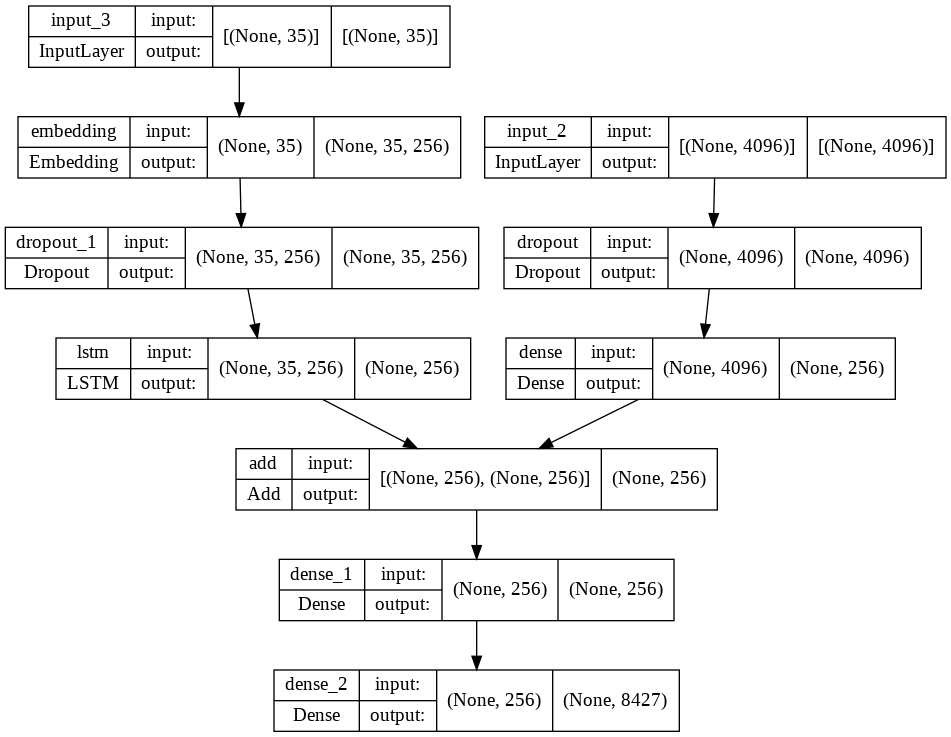

In [10]:
# Feature extractor model
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# Sequence model
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# Combine feature extractor and sequence models
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Show plot of model structure, and save plot to directory
plot_model(model, to_file='vgg16_model.png', show_shapes=True)

In [11]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 35)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 35, 256)      2157312     ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 4096)         0           ['input_2[0][0]']                
                                                                                            

In [12]:
# train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    generator = data_generator(train, caption_dict, features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

187/187 [==============================] - 47s 253ms/step - loss: 2.1429 - accuracy: 0.4522


In [13]:
# Save model to DIR
model.save(DIR+'/vgg16_model.h5')

In [14]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# Function to generate captions
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        # Encoding input seq
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # Padding the seq
        sequence = pad_sequences([sequence], max_length)
        # Predict next word
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break
        in_text += " " + word
        # Stop if end tag is reached
        if word == 'endseq':
            break
      
    return in_text

Make predictions on test data and evaluate using BLEU scores

In [15]:
actual, predicted = list(), list()

for key in tqdm(test_test):
    # Actual caption
    captions = caption_dict[key]
    # Predict caption
    predict_captions = predict_caption(model, features[key], tokenizer, max_length) 
    actual_captions = [caption.split() for caption in captions]
    predict_captions = predict_captions.split()
    actual.append(actual_captions)
    predicted.append(predict_captions)
    
# Get BLEU scores
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

  0%|          | 0/1000 [00:00<?, ?it/s]

BLEU-1: 0.523903
BLEU-2: 0.300046
BLEU-3: 0.211960
BLEU-4: 0.104169


# Displaying captions generated for sample images

In [16]:
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = caption_dict[image_id]
    print(*'Actual captions:')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print(*'Predicted caption:')
    print(y_pred)
    plt.imshow(image)

A c t u a l   c a p t i o n s :
startseq girl is reading while drinking starbuck coffee endseq
startseq seated young woman in hat is reading at coffee shop endseq
startseq woman enjoying her reading at coffee shop endseq
startseq woman in hat sits reading and drinking coffee endseq
startseq young woman sips coffee and reads book endseq
P r e d i c t e d   c a p t i o n :
startseq man in black shirt and sunglasses is looking down on the side of the street endseq


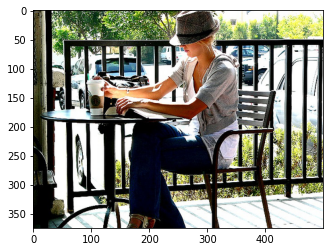

In [17]:
generate_caption("1547883892_e29b3db42e.jpg")

A c t u a l   c a p t i o n s :
startseq girl dismounts from swing as high as she can and lands on the rubber tiles below endseq
startseq girl in pink shirt jumping out of moving swing endseq
startseq little girl wearing pink shirt jumps off swing endseq
startseq young girl jumps off playground swing endseq
startseq the young girl in the pink shirt and blue jeans is jumping off the tire swing endseq
P r e d i c t e d   c a p t i o n :
startseq boy in pink shirt is jumping over trampoline in front of building endseq


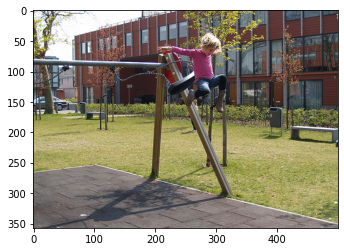

In [18]:
generate_caption("2436081047_bca044c1d3.jpg")

A c t u a l   c a p t i o n s :
startseq dog wearing number running in race endseq
startseq greyhound dog wearing yellow and black shirt runs along dirt racetrack endseq
startseq greyhound runs in race bee striped jacket number eight endseq
startseq grey dog with muzzle and with the yellow striped identification is running endseq
startseq racedog has the number endseq
P r e d i c t e d   c a p t i o n :
startseq greyhound greyhound is running on the track endseq


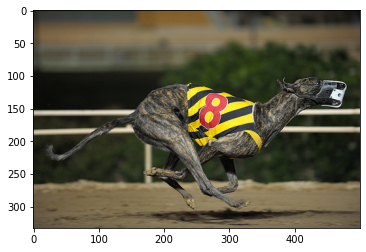

In [19]:
generate_caption("3258874419_23fec1bdc1.jpg")

A c t u a l   c a p t i o n s :
startseq little boy takes picture at the park endseq
startseq young boy is looking through binoculars at playground endseq
startseq young boy wearing blue and red hat is using camera near swing set endseq
startseq little boy takes photos outside endseq
startseq the little boy is taking picture with the camera endseq
P r e d i c t e d   c a p t i o n :
startseq man in field with camera in field endseq


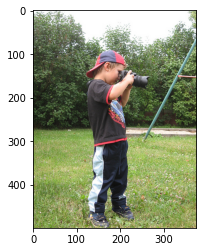

In [20]:
generate_caption("2588927489_f4da2f11ec.jpg")

A c t u a l   c a p t i o n s :
startseq boy in black winter clothes sits on an inflated sled by mound of snow endseq
startseq child rides down the snow in tube endseq
startseq the kid is on float in the snow endseq
startseq there is person sitting on plastic blow up float in the high piled snow endseq
startseq this person bundled up for the snow slides down the hill on an intertube endseq
P r e d i c t e d   c a p t i o n :
startseq child in red jacket is skating on snow endseq


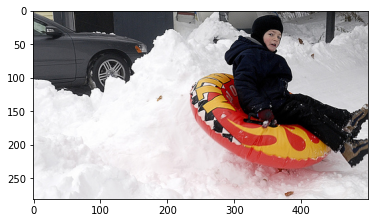

In [21]:
generate_caption("2140182410_8e2a06fbda.jpg")